<a href="https://colab.research.google.com/github/PrzemyslawSarnacki/AirQualityPrediction/blob/master/well_being_analisys.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> 

## Wstępna obróbka i Analiza danych

Wczytanie potrzebnych bibliotek

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import numpy as np
import unicodedata
from io import BytesIO
import requests
import joblib


warnings.simplefilter('ignore')
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


def strip_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text.lower().replace("ł","l")) if unicodedata.category(c) != 'Mn')

CITIES = ["Warszawa", "Kraków", "Poznań", "Katowice", "Białystok"]
COORDINATES = {
    "warszawa": {
        "latitude": 52.2297,
        "longitude": 21.0122
    },
    "krakow": {
        "latitude": 50.0647,
        "longitude": 19.9450
    },
    "poznan": {
        "latitude": 52.4064,
        "longitude": 16.9252
    },
    "katowice": {
        "latitude": 50.2649,
        "longitude": 19.0238
    },
    "bialystok": {
        "latitude": 53.1325,
        "longitude": 23.1688
    },
}
PARAMETERS = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']

indices = [""] + [f".{i}" for i in range(1, 6)]
data = {}

df = pd.read_csv("https://raw.githubusercontent.com/PrzemyslawSarnacki/AirQualityPrediction/master/data/airq_data_2.csv", index_col=0, parse_dates=True)

# load machine learning model for aqi prediction
m_link = 'https://github.com/PrzemyslawSarnacki/AirQualityPrediction/blob/master/data/aqi.joblib?raw=true'
m_file = BytesIO(requests.get(m_link).content)
aqi_model = joblib.load(m_file)

# fill columns with data
for city in CITIES:
    data[strip_accents(city)] = pd.DataFrame(df, columns=[f"{strip_accents(city)}{item}" for item in indices])
    data[strip_accents(city)] = data[strip_accents(city)].rename(columns=data[strip_accents(city)].iloc[0]).drop(data[strip_accents(city)].index[0])
    data[strip_accents(city)] = data[strip_accents(city)].astype(float).interpolate(method="linear")
    data[strip_accents(city)].index = pd.to_datetime(data[strip_accents(city)].index)
    data[strip_accents(city)]["aqi"] = aqi_model.predict(data[strip_accents(city)].fillna(0))


In [2]:
maps = pd.concat(
    [data[strip_accents(city)].resample("M").mean().tail(12) for city in CITIES]
)
cities_by_month = pd.concat(
    [data[strip_accents(city)]["aqi"].resample("M").mean().tail(12) for city in CITIES],
    axis=1,
    keys=[f"aqi_{strip_accents(city)}" for city in CITIES],
)


In [3]:
cities_by_year = pd.concat(
    [data[strip_accents(city)]["aqi"].resample("Y").mean() for city in CITIES],
    axis=1,
    keys=[f"aqi_{strip_accents(city)}" for city in CITIES],
)


In [4]:
cities_by_year

,aqi_warszawa,aqi_krakow,aqi_poznan,aqi_katowice,aqi_bialystok
2018-12-31,52.878258,74.294077,70.583435,77.924820,39.823336
2019-12-31,53.792593,57.805277,59.238825,64.604874,56.507307
2020-12-31,49.153645,53.468729,51.581511,55.844099,49.816646
2021-12-31,60.604359,76.530067,64.740758,76.305159,58.477531


## Wskaźniki samopoczucia i zdrowia 

Wprowadźmy dane z badań przeprowadzonych w UK i Chinach (A psychophysical measurement on subjective well-being and air pollution 
by Li et al. 2019) 


In [5]:
import scipy.interpolate

x_arr = np.array([0, 100, 200, 300])
well_being = {
    "irriration": np.array([0, 2, 3, 4]),
    "depression": np.array([0, 2, 3, 4]),
    "stress": np.array([0.5, 2, 3, 4]),
    "worry": np.array([1, 2, 3, 4]),
    "happiness": np.array([4, 3, 2, 1]),
    "future_expectations": np.array([4, 3, 1.5, 1]),
    "swb": np.array([4, 0, -1, -3]),
    "health_concern": np.array([0, 1, 3, 4]),
}


Narysujmy wskaźniki samopoczucia (w sensie  negatywnym)

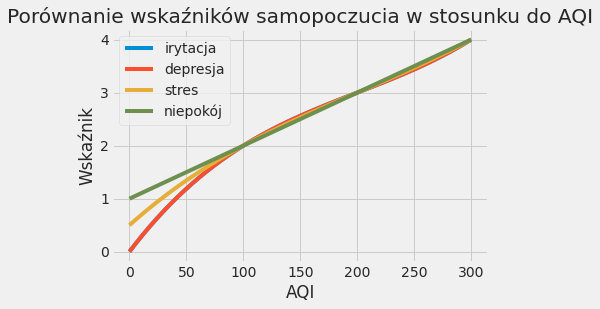

In [23]:
from itertools import islice

def get_n_items(d,f,n):
    """
    return sliced dictionary 
    f - means from (first element in the sliced array)
    n - means to (last element in the sliced array) if n exceeds size of array nothing 
    serious happens (last element is treated as n)
    """
    return dict(islice(d.items(),f, n))

plt.style.use("fivethirtyeight")

for being in get_n_items(well_being, 0, 4):
    interval = np.linspace(x_arr[0], x_arr[-1])
    interpolation = scipy.interpolate.interp1d(x_arr, well_being[being])
    spl = scipy.interpolate.UnivariateSpline(x_arr, well_being[being])
    plt.plot(interval, spl(interval))

plt.title("Porównanie wskaźników samopoczucia w stosunku do AQI")
plt.xlabel("AQI")
plt.ylabel("Wskaźnik")
plt.grid(True)
plt.legend([being for being in get_n_items(well_being, 0, 4)])
plt.legend(["irytacja", "depresja", "stres", "niepokój"])

Wskaźniki samopoczucia (w sensie pozytywnym)

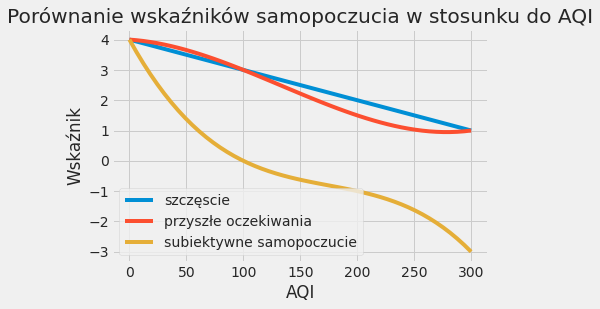

In [22]:
for being in get_n_items(well_being, 4, 7):
    interval = np.linspace(x_arr[0], x_arr[-1])
    interpolation = scipy.interpolate.interp1d(x_arr, well_being[being])
    spl = scipy.interpolate.UnivariateSpline(x_arr, well_being[being])
    plt.plot(interval, spl(interval))

plt.title("Porównanie wskaźników samopoczucia w stosunku do AQI")
plt.xlabel("AQI")
plt.ylabel("Wskaźnik")
plt.grid(True)
plt.legend([being for being in get_n_items(well_being, 4, 7)])
plt.legend(["szczęscie", "przyszłe oczekiwania", "subiektywne samopoczucie"])

Wskaźnik ogólnie pojętego zdrowia  

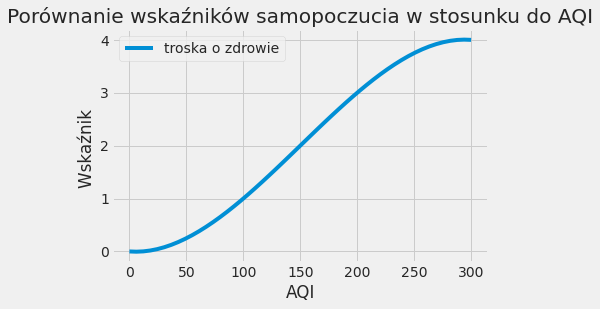

In [24]:
for being in get_n_items(well_being, 7, 8):
    interval = np.linspace(x_arr[0], x_arr[-1])
    interpolation = scipy.interpolate.interp1d(x_arr, well_being[being])
    spl = scipy.interpolate.UnivariateSpline(x_arr, well_being[being])
    plt.plot(interval, spl(interval))

plt.title("Porównanie wskaźników samopoczucia w stosunku do AQI")
plt.xlabel("AQI")
plt.ylabel("Wskaźnik ")
plt.grid(True)
plt.legend(["troska o zdrowie"])
# plt.legend([being for being in get_n_items(well_being, 7, 8)])

## Porównanie AQI pomiędzy miastami

Mapa cieplna aqi w poszczególnych miastach

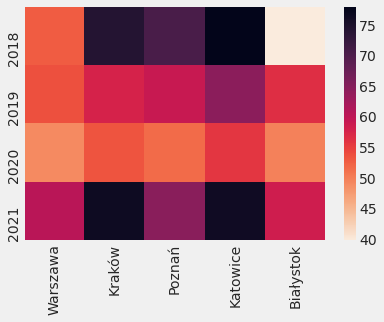

In [20]:
year_labels = [
 2018,
 2019,
 2020,
 2021
]
sns.heatmap(cities_by_year,xticklabels=CITIES, yticklabels=year_labels, cmap=sns.cm.rocket_r
)

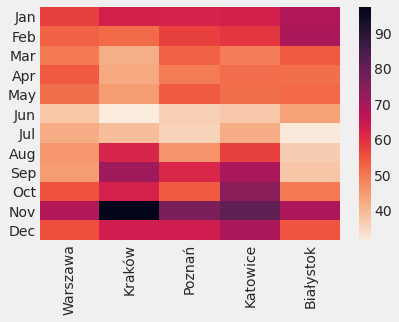

In [19]:
month_labels = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
sns.heatmap(cities_by_month, xticklabels=CITIES,yticklabels=month_labels, cmap=sns.cm.rocket_r
)

Dystrybucje wartości AQI. Jak widzimy wbrew pozorom Białystok nie posiada najlepszych warunków. Warszawa posiada za to najniższą wartość średnią, medianę, najniższe maksimum oraz ogólną dystrybucję. Najgorsze warunki posiadają Kraków i Katowice przy najwyższych maksimach i najczęściej występującej wartości submaksymalnej. 

Text(0.5, 0.99, 'DISTRIBUTIONS')

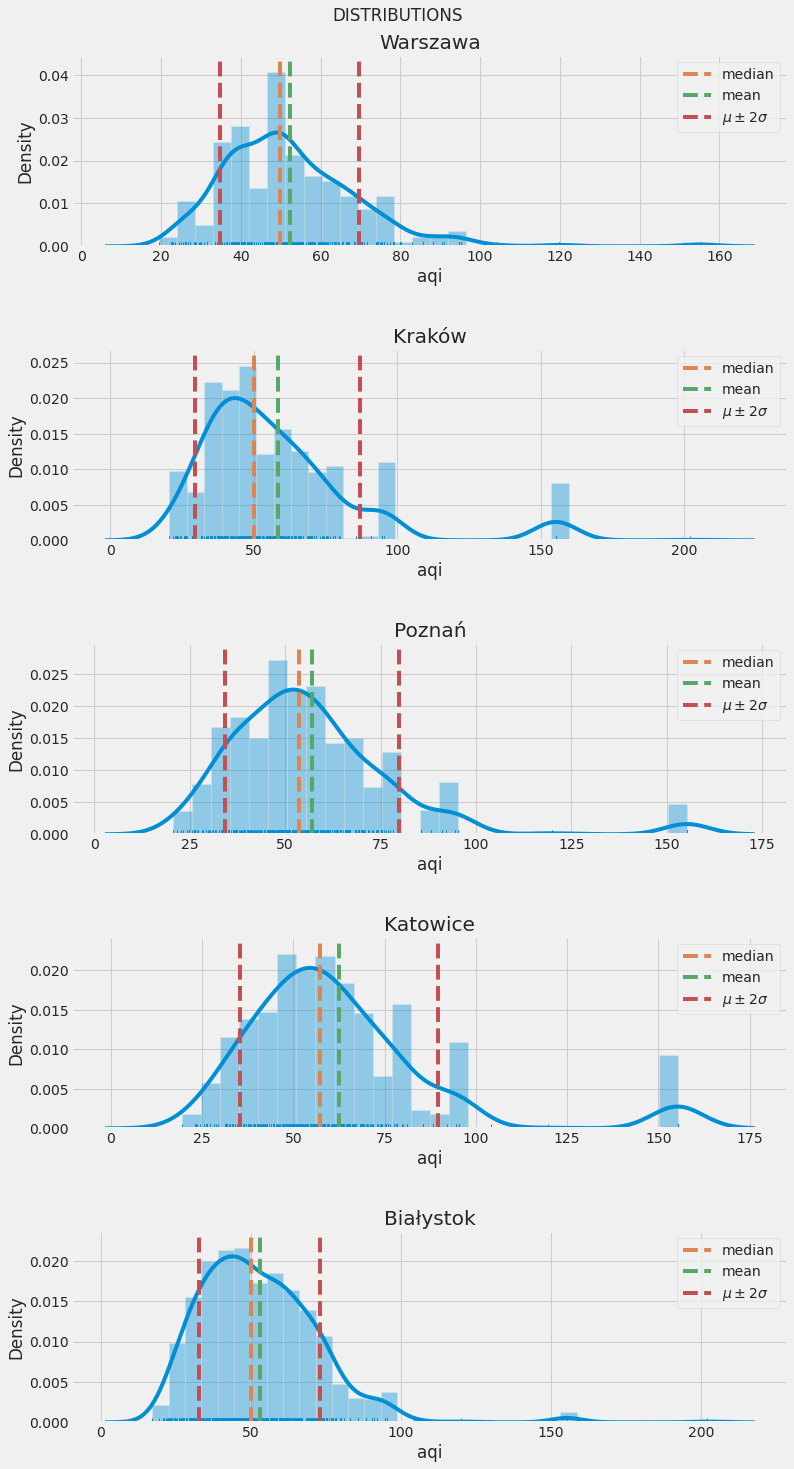

In [15]:
fig, ax = plt.subplots(len(data), 1, figsize=(12, 21))

for i, city in enumerate(CITIES):
    # print(f'{city}: mean={param_mean}, median={param_median}, std={param_std}')
    param_mean = np.mean(data[strip_accents(city)]["aqi"], axis=0)
    param_median = np.median(data[strip_accents(city)]["aqi"], axis=0)
    param_std = np.std(data[strip_accents(city)]["aqi"], axis=0)
    sns.distplot(a=data[strip_accents(city)]["aqi"], rug=True, ax=ax[i])
    ax[i].set(title=city)
    ax[i].axvline(x=param_median, color=sns_c[1], linestyle="--", label="median")

    ax[i].axvline(x=param_mean, color=sns_c[2], linestyle="--", label="mean")
    ax[i].axvline(
        x=param_mean + param_std,
        color=sns_c[3],
        linestyle="--",
        label=r"$\mu \pm 2\sigma$",
    )
    ax[i].axvline(x=param_mean - param_std, color=sns_c[3], linestyle="--")
    ax[i].legend()

plt.tight_layout(pad=3.0)
plt.suptitle("DISTRIBUTIONS", y=0.99)


Najwięcej maksimów posiadają Białystok i Kraków 

In [16]:
pd.DataFrame(
    {"min_aqi": cities_by_month.min(axis=1), "City": cities_by_month.idxmin(axis=1)}
)


,min_aqi,City
2020-04-30,57.693327,aqi_warszawa
2020-05-31,52.080285,aqi_krakow
2020-06-30,42.168627,aqi_krakow
2020-07-31,43.099686,aqi_krakow
2020-08-31,44.872319,aqi_krakow
2020-09-30,31.707089,aqi_krakow
2020-10-31,32.134366,aqi_bialystok
2020-11-30,36.960151,aqi_bialystok
2020-12-31,38.277758,aqi_bialystok
2021-01-31,50.094426,aqi_bialystok


Najwięcej maksimów posiadają również Białystok i Kraków

In [25]:
pd.DataFrame(
    {"max_aqi": cities_by_month.max(axis=1), "City": cities_by_month.idxmax(axis=1)}
)


,max_aqi,City
2020-04-30,68.629632,aqi_bialystok
2020-05-31,69.556627,aqi_bialystok
2020-06-30,54.333547,aqi_bialystok
2020-07-31,54.469986,aqi_warszawa
2020-08-31,54.330233,aqi_poznan
2020-09-30,43.749025,aqi_bialystok
2020-10-31,42.437504,aqi_katowice
2020-11-30,61.926287,aqi_krakow
2020-12-31,71.337624,aqi_krakow
2021-01-31,74.516524,aqi_katowice


In [26]:
pd.DataFrame(
    {"min_aqi": cities_by_year.min(axis=1), "City": cities_by_year.idxmin(axis=1)}
)

,min_aqi,City
2018-12-31,39.823336,aqi_bialystok
2019-12-31,53.792593,aqi_warszawa
2020-12-31,49.153645,aqi_warszawa
2021-12-31,58.477531,aqi_bialystok


In [27]:
pd.DataFrame(
    {"max_aqi": cities_by_year.max(axis=1), "City": cities_by_year.idxmax(axis=1)}
)

,max_aqi,City
2018-12-31,77.924820,aqi_katowice
2019-12-31,64.604874,aqi_katowice
2020-12-31,55.844099,aqi_katowice
2021-12-31,76.530067,aqi_krakow
